In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
#from bayes_opt import BayesianOptimization

Here we will put all the function at the same time, then after we will execute one after another our main

In [6]:
# Function to explore the data
def explore_data(df):
    print(df.describe())
    print(df.isnull().sum())
    print(df.dtypes)

# Function for feature engineering
def engineer_features(df):
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek # this is a panda function that give the nmber of the date (weeknd are 5, 6) Monday is 0
    df['Month'] = df['Date'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    return df


# Function for data cleaning
def clean_data(df):
    df.fillna(df.mean(), inplace=True)  # Example: fill missing values with the mean
    # Add other data cleaning steps here
    return df

In [7]:
# Function for data transformation
def transform_data1(df, target_column_name):
    # Drop the target column and any non-numeric columns
    # attention there are categorical data that shouldn't be scaled, so w have exclude them
    X = df.select_dtypes(include=[np.number]).drop([target_column_name], axis=1)
    y = df[target_column_name]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Convert the scaled features back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    return X_scaled_df, y


# Assuming 'Date' column or any datetime type columns are correctly excluded from X_to_scale
def transform_data(df, target_column_name, exclude_from_scaling=None):
    if exclude_from_scaling is None:
        exclude_from_scaling = []

    # Ensure 'Date' column is also excluded if still present
    df_numeric = df.select_dtypes(include=[np.number, 'bool'])  # 'bool' included if you have boolean types
    X = df_numeric.drop([target_column_name] + exclude_from_scaling, errors='ignore', axis=1)
    y = df[target_column_name]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # you may ask why: After scaling, X_scaled is a NumPy array
    # without the column names, because the scaling operation returns a NumPy array. This line converts X_scaled back
    # into a pandas

    # Re-include the excluded features without scaling
    X_excluded = df[exclude_from_scaling].reset_index(drop=True)
    X_final = pd.concat([X_scaled_df, X_excluded], axis=1)
    print("Make sure transformation is well done:")
    print(X_final)
    return X_final, y


In [8]:
# Function to split the data
def split_data(X, y, test_size=0.2, random_state=203):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [9]:
###
    # we start with SVR, but it will works with others models
def train_model(X_train, y_train, technique, params):
    """
    Trains an SVR model based on the specified technique and parameters.

    :param X_train: Training feature dataset.
    :param y_train: Training target dataset.
    :param technique: Specifies the technique to use.
                      "SVR default" for default parameters, "SVR" for custom parameters.
    :param params: Dictionary of parameters for the SVR model.
    :return: Trained SVR model.
    """
    if technique == "SVR default":
        model = SVR()
    elif technique == "SVR":
        model = SVR(**params)
    else:
        raise ValueError("Unsupported technique specified.")

    model.fit(X_train, y_train)
    return model

In [10]:
def evaluate_model(model, X_test, y_test):
    """

    :type model: this is a trained model, and it's coming from the returned value of train_model
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Print the evaluation metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2 Score: {r2}")

    return predictions, mse, mae, rmse, r2

In [11]:
def perform_grid_search(X_train, y_train):  # i don't like it. it only works with SVR, but we will leave it to later
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [12]:
def perform_random_search(X_train, y_train, model, param_dist, n_iter=100):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_score_

In [13]:
def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

In [14]:
def plotting(predictions, y_test):
    plt.figure(figsize=(14, 7))
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.plot(y_test.values, label='Actual', alpha=0.5)  # Ensure y_test is a series, so we access .values
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Time/Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

bissmillah let's run

In [19]:
path= r'H:\perso\thesis\data\germany_2023.xlsx'
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
explore_data(df)

       Cross border electricity trading      Nuclear  Non-Renewable  \
count                       8760.000000  2519.000000    8760.000000   
mean                        1325.121128  2669.164192   19226.142071   
std                         6967.797229   316.896848    9244.116161   
min                       -19226.890000   270.970000    5911.930000   
25%                        -3555.625000  2405.305000   12020.692500   
50%                         1597.055000  2791.620000   16963.775000   
75%                         6679.317500  2942.390000   23860.815000   
max                        16836.270000  3075.230000   45778.400000   

          Renewable  Day Ahead Auction  
count   8760.000000        8760.000000  
mean   29730.528659          95.175452  
std    12691.633520          47.584215  
min     7956.640000        -500.000000  
25%    18876.600000          75.877500  
50%    28608.070000          98.020000  
75%    39316.577500         122.120000  
max    64702.740000         524.

In [20]:
df= engineer_features(df)
print(df.head())

                 Date  Cross border electricity trading  Nuclear  \
0 2023-01-01 00:00:00                         -12557.67  2453.98   
1 2023-01-01 01:00:00                         -15382.57  2453.41   
2 2023-01-01 02:00:00                         -16357.49  2454.45   
3 2023-01-01 03:00:00                         -14005.91  2455.28   
4 2023-01-01 04:00:00                         -14544.00  2455.61   

   Non-Renewable  Renewable  Day Ahead Auction  Hour  DayOfWeek  Month  \
0        9146.70   38385.16              -5.17     0          6      1   
1        8925.67   39415.74              -1.07     1          6      1   
2        8902.45   39610.87              -1.47     2          6      1   
3        8901.06   37023.96              -5.08     3          6      1   
4        8863.20   36499.99              -4.49     4          6      1   

   IsWeekend  
0          1  
1          1  
2          1  
3          1  
4          1  


In [21]:
df = clean_data(df)
            #centrer et reduire
X_scaled, y = transform_data(df, target_column_name, ['Hour', 'DayOfWeek', 'Month', 'IsWeekend'])
            #splitting the data
X_train, X_test, y_train, y_test = split_data(X_scaled, y)

Make sure transformation is well done:
      Cross border electricity trading   Nuclear  Non-Renewable  Renewable  \
0                            -1.992536 -1.266533      -1.090425   0.681955   
1                            -2.397981 -1.269888      -1.114337   0.763161   
2                            -2.537907 -1.263767      -1.116849   0.778537   
3                            -2.200395 -1.258882      -1.116999   0.574697   
4                            -2.277625 -1.256939      -1.121095   0.533410   
...                                ...       ...            ...        ...   
8755                         -1.207801  0.000000      -1.050898   1.057336   
8756                         -1.374797  0.000000      -1.088361   1.120787   
8757                         -1.436292  0.000000      -1.087969   1.119148   
8758                         -1.605489  0.000000      -1.095011   1.115435   
8759                         -1.831431  0.000000      -1.095676   1.111305   

      Hour  DayOfWeek  M

C:\Users\mohamedabdellahimo\AppData\Local\Temp\ipykernel_1932\1579396396.py:18: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)  # Example: fill missing values with the mean


In [22]:
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
}


In [23]:
# Specify distributions rather than a list of options
param_dist = { # for random research
    'C': reciprocal(0.1, 1000),
    'gamma': expon(scale=1.0),
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

In [25]:
#######------------------- Model training and evaluation
# Hyperparameter tuning
start_timeCalibration= time.time()
best_params, best_score = tune_hyperparameters(X_train, y_train, SVR(), param_grid)
end_timeCalibration = time.time()
calibration_time = end_timeCalibration - start_timeCalibration

In [28]:
print(f"Calibration time for Grid Research: {calibration_time} seconds")

Calibration time for Grid Research: 126.33413982391357 seconds


In [29]:
start_timeCalibrationRnd = time.time()
best_paramsRandom, best_scoreRandom = perform_random_search(X_train, y_train, SVR(), param_dist, n_iter=100)
end_timeCalibrationRnd = time.time()
calibration_timeRnd = end_timeCalibrationRnd - start_timeCalibrationRnd
print(f"Calibration time for Random search: {calibration_timeRnd} seconds")

Calibration time for Random search: 448.61991333961487 seconds


In [30]:
start_time_training= time.time()
model= train_model(X_train, y_train,"SVR", best_params)   #here we train the model
model2 = train_model(X_train, y_train, "SVR", best_paramsRandom)
end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Training time: {training_time} seconds")

Training time: 89.19936227798462 seconds


In [32]:
#predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)
evaluate_model(model, X_test, y_test)

Mean Squared Error: 207.74577644806962
Mean Absolute Error: 9.356045870774254
Root Mean Squared Error: 14.413388791261742
R^2 Score: 0.9046018547109308


(array([  4.1372423 ,  74.07193248,  96.18247446, ..., 140.49442285,
        183.40852893,  -0.85070796]),
 207.74577644806962,
 9.356045870774254,
 14.413388791261742,
 0.9046018547109308)

In [33]:
print(f"model with random search")
evaluate_model(model2, X_test, y_test)

model with random search
Mean Squared Error: 152.1909321059062
Mean Absolute Error: 8.135151971551306
Root Mean Squared Error: 12.336568895195544
R^2 Score: 0.9301129827958386


(array([  4.57003288,  74.33027031,  93.7927874 , ..., 155.01723664,
        181.57030797,   0.78838061]),
 152.1909321059062,
 8.135151971551306,
 12.336568895195544,
 0.9301129827958386)

In [34]:
predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)

Mean Squared Error: 207.74577644806962
Mean Absolute Error: 9.356045870774254
Root Mean Squared Error: 14.413388791261742
R^2 Score: 0.9046018547109308


In [35]:
predictions1, mse1, mae1, rmse1, r2= evaluate_model(model2, X_test, y_test)

Mean Squared Error: 152.1909321059062
Mean Absolute Error: 8.135151971551306
Root Mean Squared Error: 12.336568895195544
R^2 Score: 0.9301129827958386


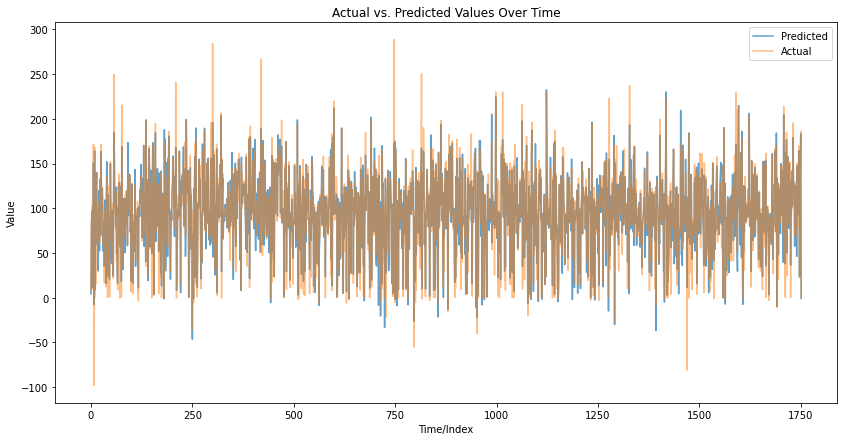

In [36]:
# Graphical presenetation
plotting(predictions, y_test)

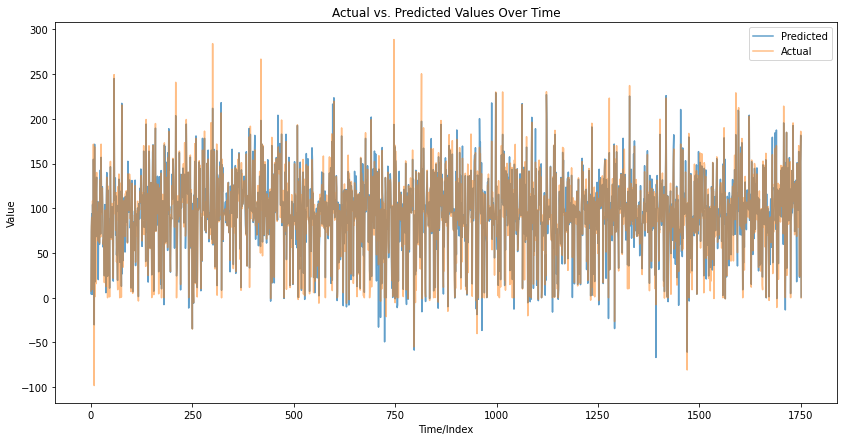

In [37]:
plotting(predictions1, y_test)